In [43]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import sys
import math
import os
import time
import numpy as np
import nltk
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
nltk.download('stopwords')

# local code
sys.path.insert(1, "./code/")
from Utils import Utils # student's library
from Eval import Eval # student's library
from Extract import Extract # student's library


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [45]:
# sanity checks
#train_df.id.nunique()
# 19579

#train_df.author.unique()
# array(['EAP', 'HPL', 'MWS'], dtype=object)

In [46]:
Utils.check_for_nulls(train_df)

{'author': 0, 'id': 0, 'text': 0}

In [47]:
# splitting data

# regular data
#     train: 19580 * .9 rows
#     test:  8393 rows
#     val:   19580 * .1 rows


if os.path.isfile('data/traindata.pickle'):
    traindata = pd.read_pickle('data/traindata.pickle')
    valdata   = pd.read_pickle('data/valdata.pickle')
    testdata  = pd.read_pickle('data/testdata.pickle')
else: 
    VAL_IDX  = math.ceil(len(train_df) * .8)
    TEST_IDX = math.ceil(len(train_df) * .9)

    traindata = train_df[:VAL_IDX]
    valdata   = train_df[VAL_IDX:TEST_IDX]
    testdata  = train_df[TEST_IDX:]

    print(VAL_IDX, TEST_IDX)

    traindata.to_pickle('data/traindata.pickle')
    valdata.to_pickle('data/valdata.pickle')
    testdata.to_pickle('data/testdata.pickle')

In [48]:
print("traindata: {}, valdata: {}, testdata: {}".format(len(traindata), len(valdata), len(testdata)))

traindata: 15664, valdata: 1958, testdata: 1957


In [49]:
def logtime():
    timenow = time.asctime( time.localtime(time.time()) )
    print("Finished at: ", timenow)
logtime()

Finished at:  Mon Dec 10 01:50:52 2018


# Feature engineering

In [50]:
# labels
Y_train = list(traindata.author )
Y_val = list(valdata.author)
Y_test = list(testdata.author)

In [51]:
# grammatical feature engineering 
# we want to include stopwords here

def gen_gram_feats(name, seq_no, train, val, test):
    train_df = Extract.gram_feats(train.text, None, seq_no)

    # need to remember so that val/test process
    # does not add additional columns
    gram_feat_list = list(train_df.columns)

    val_df = Extract.gram_feats(val.text, gram_feat_list, seq_no)
    test_df = Extract.gram_feats(test.text, gram_feat_list, seq_no)

    # removes a singleton feature
    for df in [train_df, val_df, test_df]:
        if 'SYM_count' in list(df.columns):
            df.drop('SYM_count', axis=1, inplace=True)
        
    train_df.to_pickle('data/train_' + name + '_df.pickle')
    val_df.to_pickle('data/val_' + name + '_df.pickle')
    test_df.to_pickle('data/test_' + name + '_df.pickle')       


if os.path.isfile('data/train_gram_df.pickle'):
    print("reading gram feats from pickle")
    # pass
else:
    print("writing gram feats pickles")
    gen_gram_feats('gram', None, traindata, valdata, testdata)
    gen_gram_feats('gram_seq', 7, traindata, valdata, testdata)
    
train_gram_df = pd.read_pickle('data/train_gram_df.pickle')
val_gram_df   = pd.read_pickle('data/val_gram_df.pickle')
test_gram_df  = pd.read_pickle('data/test_gram_df.pickle')

train_gram_seq_df = pd.read_pickle('data/train_gram_seq_df.pickle')
val_gram_seq_df   = pd.read_pickle('data/val_gram_seq_df.pickle')
test_gram_seq_df  = pd.read_pickle('data/test_gram_seq_df.pickle')
    
logtime()

reading gram feats from pickle
Finished at:  Mon Dec 10 01:50:53 2018


In [52]:
print(train_gram_df.shape)
print(val_gram_df.shape)
print(test_gram_df.shape)

print(train_gram_seq_df.shape)
print(val_gram_seq_df.shape)
print(test_gram_seq_df.shape)

assert(train_gram_df.shape == (15664, 23))
assert(train_gram_seq_df.shape == (15664, 1622))
#set(GRAM_FEAT_LIST) - set(list(val_gram_feats_df.columns))

(15664, 23)
(1958, 23)
(1957, 23)
(15664, 1622)
(1958, 1622)
(1957, 1622)


In [53]:
train_gram_seq_df.head()

,,ADJ_count,ADP_count,ADV_count,CCONJ,CCONJ_CCONJ_CCONJ_VERB_NOUN,CCONJ_CCONJ_NOUN,CCONJ_CCONJ_NOUN_CCONJ_NOUN_CCONJ_NOUN,CCONJ_CCONJ_NOUN_CCONJ_NOUN_NOUN_VERB,CCONJ_CCONJ_NOUN_CCONJ_NOUN_VERB_VERB,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
0,0.0,0.235080,0.513819,0.627603,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.363031,0.277382,0.0,-0.1611,-0.018801,0.0,-0.237475,2.918125,0.762854
1,0.0,-0.737871,-0.660999,0.084256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.191755,-0.288286,0.0,-0.1611,-0.018801,0.0,-0.237475,-0.440646,-0.726940
2,0.0,1.208031,0.513819,-0.459090,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.199733,0.923860,0.0,-0.1611,-0.018801,0.0,-0.237475,-0.440646,0.474207
3,0.0,0.883714,0.513819,0.084256,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.493349,0.439002,0.0,-0.1611,-0.018801,0.0,-0.237475,-0.440646,0.530074
4,0.0,0.235080,-0.367294,1.170950,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.150797,-0.409501,0.0,-0.1611,-0.018801,0.0,-0.237475,1.238739,0.232115


In [54]:
# textual feature engineering
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_features=1500)

train_text_feats = vectorizer.fit_transform(traindata.text)
val_text_feats = vectorizer.transform(valdata.text) 
test_text_feats = vectorizer.transform(testdata.text) 

cols = ["text_" + str(x) for x in range(train_text_feats.shape[1])]

train_text_feats_df = pd.DataFrame(train_text_feats.todense(), index=None, columns=cols)
val_text_feats_df = pd.DataFrame(val_text_feats.todense(), index=None, columns=cols)
test_text_feats_df = pd.DataFrame(test_text_feats.todense(), index=None, columns=cols)

print(train_text_feats_df.shape)
print(val_text_feats_df.shape)
print(test_text_feats_df.shape)


(15664, 1500)
(1958, 1500)
(1957, 1500)


In [55]:
# persist to disk
# if not os.path.isfile('data/train_text_feats_df.pickle'):
#     train_text_feats_df.to_pickle('data/train_text_feats_df.pickle')
#     val_text_feats_df.to_pickle('data/val_text_feats_df.pickle')
#     test_text_feats_df.to_pickle('data/test_text_feats_df.pickle')  

In [56]:
train_text_feats_df.head()

,text_0,text_1,text_2,text_3,text_4,text_5,text_6,text_7,text_8,text_9,...,text_1490,text_1491,text_1492,text_1493,text_1494,text_1495,text_1496,text_1497,text_1498,text_1499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.225799,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [57]:
# gensim feature engineering
import numpy as np
import gensim
GENSIM = True

if GENSIM:
    logtime()
    #https://radimrehurek.com/gensim/models/doc2vec.html
    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
    #TaggedDocument does not filter or stem

    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(traindata.text))]
    model = Doc2Vec(documents, vector_size=1500, window=2, min_count=1, workers=4)

    train_gensim = np.array([model.infer_vector(x) for x in list(traindata.text)])
    val_gensim = np.array([model.infer_vector(x) for x in list(valdata.text)])
    test_gensim = np.array([model.infer_vector(x) for x in list(testdata.text)])

    # numpy to pandas
    cols = ["gensim_" + str(x) for x in range(len(train_gensim[0]))]

    train_gensim_df = pd.DataFrame(train_gensim, index=None, columns=cols)
    val_gensim_df = pd.DataFrame(val_gensim, index=None, columns=cols)
    test_gensim_df = pd.DataFrame(test_gensim, index=None, columns=cols)
    logtime()
    
# gensim didn't help. so we're settling on tfidf extual features for now, and will explore neural models


Finished at:  Mon Dec 10 01:50:54 2018
Finished at:  Mon Dec 10 01:51:19 2018


# Exploration

In [58]:
# lex = Utils.build_lexicon(traindata.text, STOPWORDS)
# len(lex)

# 22847 different tokens in full lexicon

In [59]:
mws_df = train_df[train_df.author == 'MWS']
hpl_df = train_df[train_df.author == 'HPL']
eap_df = train_df[train_df.author == 'EAP']

cutoff = min([mws_df.shape[0], hpl_df.shape[0], eap_df.shape[0]])

# equalize corpus sizes to avoid bias during exploration
mws_df = mws_df[:cutoff]
hpl_df = hpl_df[:cutoff]
eap_df = eap_df[:cutoff]

mws_lexicon = Utils.build_lexicon(mws_df.text, STOPWORDS)
hpl_lexicon = Utils.build_lexicon(hpl_df.text, STOPWORDS)
eap_lexicon = Utils.build_lexicon(eap_df.text, STOPWORDS)

# sanity check
assert(cutoff * 3 == len(mws_df) + len(hpl_df) + len(eap_df))

# add grammatical features (for exploration this time, not training)
mws_gram_feats_df = Extract.gram_feats(mws_df.text, None, None)
hpl_gram_feats_df = Extract.gram_feats(hpl_df.text, None, None)
eap_gram_feats_df = Extract.gram_feats(eap_df.text, None, None)

mws_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
count,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,...,5.635000e+03,5.635000e+03,5.635000e+03,5635.0,5.635000e+03,5635.0,5635.0,5.635000e+03,5.635000e+03,5.635000e+03
mean,5.043782e-18,6.777582e-17,2.395796e-17,-7.187389e-17,9.457091e-18,2.521891e-18,4.980734e-17,1.670753e-17,1.891418e-18,4.224167e-17,...,7.880909e-20,1.387040e-17,4.539403e-17,0.0,-3.120840e-17,0.0,0.0,1.639229e-17,-7.565672e-18,-3.152364e-17
std,1.000000e+00,9.609892e-01,1.000000e+00,8.428109e-01,9.289644e-01,1.797328e-01,1.000000e+00,3.101639e-01,6.326520e-01,9.163641e-01,...,5.807221e-02,1.000000e+00,1.000000e+00,0.0,1.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.669821e-01,-8.362820e-01,-8.746468e-01,-6.749403e-01,-7.230532e-01,-2.697985e-01,-1.032234e+00,-3.935250e-01,-5.018364e-01,-6.978646e-01,...,-2.874173e-01,-1.238327e+00,-9.793490e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,-5.894256e-01,-1.017688e+00
25%,-6.949294e-01,-5.730821e-01,-8.746468e-01,-6.749403e-01,-3.758420e-01,0.000000e+00,-4.800391e-01,0.000000e+00,-5.018364e-01,-6.978646e-01,...,0.000000e+00,-4.909876e-01,-9.793490e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,-5.894256e-01,-5.281714e-01
50%,-1.508239e-01,-4.668209e-02,-3.236535e-01,0.000000e+00,-2.863082e-02,0.000000e+00,-1.119090e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.920516e-01,-1.519656e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,-5.894256e-01,-1.785166e-01
75%,3.932816e-01,2.165179e-01,2.273397e-01,9.130644e-02,3.185804e-01,0.000000e+00,2.562212e-01,0.000000e+00,0.000000e+00,1.000804e-01,...,0.000000e+00,2.563523e-01,4.685719e-01,0.0,-2.231806e-01,0.0,0.0,-2.097765e-01,7.428701e-01,3.110000e-01
max,3.059114e+01,3.311652e+01,2.171608e+01,1.924748e+01,3.226201e+01,7.693608e+00,3.449232e+01,7.238050e+00,1.794448e+01,2.443740e+01,...,4.023842e+00,9.224431e+00,6.467101e+00,0.0,1.138564e+01,0.0,0.0,2.594267e+01,7.404349e+00,3.505114e+01


In [60]:
# looks like sentence length values are consistently higher by at least a degree of magnitude
# so we'll take the log
# This is not done via the standardize() method

# for df in [mws_gram_feats_df, hpl_gram_feats_df, eap_gram_feats_df]:
#     df['sent_len'] = df['sent_len'].apply(lambda x: math.log(x))
#     df.rename(inplace=True, columns={'sent_len': 'log_sent_len'})


In [61]:
# NER exploration

# avoiding NER for three reasons:
# features very sparse
# features seem content-specific, so may contribute to misprediction
# should we add data from the same authors about other topics

NER = False
if NER:
    import spacy
    spacy_mdl = spacy.load('en_core_web_sm')

    def sent_to_ents(sent, spacy):
        sent = spacy(sent)
        ents = []
        for ent in sent.ents:
            ents.append(ent.text + ':' + ent.label_)
        return ents

    entities = []
    for i in range(1500):
        sent = valdata.iloc[i].text
        ents = sent_to_ents(sent, spacy_mdl)
        entities.append(ents)
 

# example entities list HERE
# many sentences don't have any entities, like below
#'In whatever way the shifting is managed, it is of course concealed at every step from observation.'

In [62]:
if NER:
    import statistics as stat
    entity_freq = [len(x) for x in entities]


    print("stats for NER within a sample group: \n")
    print("min: {} \nmax: {} \nmean: {} \nstdev: {}" \
          .format(min(entity_freq), max(entity_freq), stat.mean(entity_freq), stat.stdev(entity_freq)))



# Exploration - visualization

In [63]:
# data viz

def plot_word_freq(lexicon, name, quantity=20):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    elems = [x[0] for x in lexicon[:quantity]]
    y_pos = np.arange(quantity)
    vals = [x[1] for x in lexicon[:quantity]]

    ax.barh(y_pos, vals, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(elems)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Corpus-wide frequency')
    ax.set_title(name + ' - Word Frequencies')

    plt.show()
 
authors = {'MWS': mws_lexicon, 'HPL': hpl_lexicon, 'EAP': eap_lexicon}

pd.set_option('display.max_colwidth', -1)
print("Example MWS sentence: \n{}\n".format(mws_df.text[:1].to_string()))
print("Example HPL sentence: \n{}\n".format(hpl_df.text[:1].to_string()))
print("Example EAP sentence: \n{}\n".format(eap_df.text[:1].to_string()))
pd.set_option('display.max_colwidth', 80)

# for key in authors: 
#     plot_word_freq(authors[key], key)


Example MWS sentence: 
3    How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.

Example HPL sentence: 
1    It never once occurred to me that the fumbling might be a mere mistake.

Example EAP sentence: 
0    This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.



In [64]:
def plot_box(df, subset):
    features = {
        'tag_features': [
             'ADJ_count',
             'ADP_count',
             'ADV_count',
             'CCONJ_count',
             'DET_count',
             'NOUN_count',
             'PRON_count',
             'VERB_count'],
        'punc_features': [
            'bang_count',
            'colon_count',
            'ellipse_count',
            'lparen_count',
            'quote_count',
            'semicolon_count'],
        'ratio_features': [
             'adj_noun_ratio',
             'adv_verb_ratio',
             'log_sent_len']
    }
    
    fig, ax = plt.subplots()
    boxplot = df.boxplot(column=features[subset], \
        showfliers=False, fontsize=6, figsize=None)
    plt.show()

In [65]:
#plot_box(mws_gram_feats_df, 'ratio_features')

In [66]:
#plot_box(hpl_gram_feats_df, 'ratio_features')

In [67]:
#plot_box(eap_gram_feats_df, 'ratio_features')

In [68]:
#plot_box(mws_gram_feats_df, 'tag_features')

In [69]:
#plot_box(hpl_gram_feats_df, 'tag_features')

In [70]:
#plot_box(eap_gram_feats_df, 'tag_features')

In [71]:
#plot_box(mws_gram_feats_df, 'punc_features')

In [72]:
#plot_box(hpl_gram_feats_df, 'punc_features')

In [73]:
#plot_box(eap_gram_feats_df, 'punc_features')

In [74]:
eap_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
count,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,5.635000e+03,...,5.635000e+03,5.635000e+03,5.635000e+03,5635.0,5.635000e+03,5.635000e+03,5635.0,5.635000e+03,5.635000e+03,5.635000e+03
mean,-3.278458e-17,3.782836e-18,-3.908931e-17,4.413309e-17,9.330996e-17,-7.880909e-19,9.330996e-17,-1.008756e-17,-3.026269e-17,-1.052889e-16,...,1.418564e-18,1.525744e-16,1.008756e-17,0.0,1.040280e-17,-3.152364e-18,0.0,6.809105e-17,-1.197898e-17,-4.287214e-17
std,1.000000e+00,9.436558e-01,1.000000e+00,7.660251e-01,9.423383e-01,1.747253e-01,1.000000e+00,3.663131e-01,5.880118e-01,8.508802e-01,...,1.270903e-01,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.023842e+00,-9.239556e-01,-9.682718e-01,-5.978215e-01,-9.095897e-01,-4.410888e-01,-1.177239e+00,-3.619786e-01,-5.497347e-01,-7.627328e-01,...,-6.347297e-01,-1.114391e+00,-9.871867e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,-1.122274e+00
25%,-6.729724e-01,-6.505018e-01,-4.682982e-01,-5.978215e-01,-5.604881e-01,0.000000e+00,-7.168663e-01,0.000000e+00,0.000000e+00,-7.627328e-01,...,0.000000e+00,-5.875971e-01,-9.871867e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,-6.953480e-01
50%,-3.221027e-01,-1.035942e-01,-4.682982e-01,0.000000e+00,-2.113865e-01,0.000000e+00,-2.564934e-01,0.000000e+00,0.000000e+00,-8.636901e-02,...,0.000000e+00,-1.925014e-01,-1.585799e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,-2.498604e-01
75%,3.796366e-01,1.698596e-01,5.316489e-01,0.000000e+00,1.377151e-01,0.000000e+00,4.340658e-01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.849059e-01,3.938247e-01,0.0,-1.429028e-01,-3.088445e-02,0.0,-2.089280e-01,-3.297344e-01,3.998090e-01
max,1.266008e+01,1.630363e+01,8.531226e+00,9.254316e+00,1.445088e+01,6.587313e+00,1.424525e+01,1.828845e+01,8.596645e+00,8.706361e+00,...,4.498908e+00,8.104509e+00,6.194072e+00,0.0,1.887892e+01,4.693064e+01,0.0,2.887605e+01,2.067601e+01,1.291059e+01


In [75]:
# strangely enough, grepping through the raw input indeed shows that no bang characters exist
# the boxplots indicate that the grammatical features indeed don't seem to have much 
# predictive power, so we'll try other features.

# Model selection, training, prediction

# data marshalling and pipelining

In [76]:
# for each, remove and review score. 5 runs total

# accepts: dataframes
# returns: ndarrays
def assemble_data(pipeline):
    def multijoin(dfs):
        agg = dfs.pop(0)
        for df in dfs:
            agg = agg.join(df)
        return agg
    
    X_train = multijoin(pipeline['train']).values
    X_val = multijoin(pipeline['val']).values
    X_test = multijoin(pipeline['test']).values
    
#     X_train.to_pickle('data/train_all.pickle')
#     X_val.to_pickle('data/val_all.pickle')
#     X_test.to_pickle('data/test_all.pickle')

    assert(X_train.shape[1] == X_val.shape[1] == X_test.shape[1])
    return {'train': X_train, 'val': X_val, 'test': X_test}


## Linear

In [77]:
def train_n_run(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    lin_clf = LinearSVC()
    lin_clf.fit(X_train, Y_train) 
    
    preds = lin_clf.predict(X_val)
    accuracy = Eval.get_accuracy(preds, Y_val)
    print("Val Accuracy: ", accuracy)
    
    preds = lin_clf.predict(X_test)
    accuracy = Eval.get_accuracy(preds, Y_test)
    print("Test Accuracy: ", accuracy)
    


In [78]:
#train_n_run(X_train, Y_train, X_val, Y_val, X_test, Y_test)

## Neural

In [79]:
# preprocessing for NN
encoder = sklearn.preprocessing.LabelEncoder()
encoder.fit(traindata.author)

Y_train_nn = tf.keras.utils.to_categorical(encoder.transform(traindata.author))
Y_val_nn   = tf.keras.utils.to_categorical(encoder.transform(valdata.author))
Y_test_nn  = tf.keras.utils.to_categorical(encoder.transform(testdata.author))


In [80]:
def nn_mdl_simple():
    # inspired by keras docs example: https://www.tensorflow.org/guide/keras#input_numpy_data

    # simple NN - but from a BOW perspective.
    # we hypothesize that signal is to be recovered from the sequence of features,
    # so we'll try RNNs next

    model = tf.keras.Sequential([
    # Adds a densely-connected layer with 64 units to the model:
    tf.keras.layers.Dense(100, activation='relu'),
    # Add another:
    tf.keras.layers.Dense(100, activation='relu'),
    # Add a softmax layer with 10 output units:
    tf.keras.layers.Dense(3, activation='softmax')])

    # Configure a model for categorical classification.
    model.compile(optimizer=tf.train.RMSPropOptimizer(0.01),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy]
                  )
    return model

In [ ]:
#all
# pipeline = { \
#     'train': [train_gram_seq_df, train_text_feats_df, train_gensim_df], 
#     'val': [val_gram_seq_df, val_text_feats_df, val_gensim_df], 
#     'test': [test_gram_seq_df, test_text_feats_df, test_gensim_df]}            

# X = {}
# X['train'] = pd.read_pickle('data/train_all.pickle').values
# X['val'] = pd.read_pickle('data/val_all.pickle').values
# X['test'] = pd.read_pickle('data/test_all.pickle').values
#X = assemble_data(pipeline)

#no seq
pipeline2 = { \
    'train': [train_gram_df, train_text_feats_df, train_gensim_df], 
    'val': [val_gram_df, val_text_feats_df, val_gensim_df], 
    'test': [test_gram_df, test_text_feats_df, test_gensim_df]}  

# no text
pipeline3 = { \
    'train': [train_gram_df, train_gensim_df], 
    'val': [val_gram_df, val_gensim_df], 
    'test': [test_gram_df, test_gensim_df]}  

# no gensim
pipeline4 = { \
    'train': [train_gram_df, train_text_feats_df], 
    'val': [val_gram_df, val_text_feats_df], 
    'test': [test_gram_df, test_text_feats_df]}  



for pipeline in [pipeline2]:
    X = assemble_data(pipeline)
    
    model = nn_mdl_simple()
    model.fit(X['train'], Y_train_nn, epochs=20, batch_size=32)
    numerical_preds = model.predict(X['val'], verbose=2 )
    Eval.nn_accuracy(encoder.classes_, numerical_preds, Y_val)    
    
    model = nn_mdl_simple()
    model.fit(X['train'], Y_train_nn, epochs=40, batch_size=32)
    numerical_preds = model.predict(X['val'], verbose=2 )
    Eval.nn_accuracy(encoder.classes_, numerical_preds, Y_val)  

    model = nn_mdl_simple()
    model.fit(X['train'], Y_train_nn, epochs=80, batch_size=32)
    numerical_preds = model.predict(X['val'], verbose=2 )
    Eval.nn_accuracy(encoder.classes_, numerical_preds, Y_val) 
    
    model = nn_mdl_simple()
    model.fit(X['train'], Y_train_nn, epochs=160, batch_size=32)
    numerical_preds = model.predict(X['val'], verbose=2 )
    Eval.nn_accuracy(encoder.classes_, numerical_preds, Y_val) 

Epoch 1/20
15664/15664 [==============================] - 5s 338us/step - loss: 0.8322 - categorical_accuracy: 0.6146
Epoch 2/20
15664/15664 [==============================] - 5s 296us/step - loss: 0.5775 - categorical_accuracy: 0.7659
Epoch 3/20
15664/15664 [==============================] - 5s 292us/step - loss: 0.5107 - categorical_accuracy: 0.7970
Epoch 4/20
15664/15664 [==============================] - 5s 297us/step - loss: 0.4642 - categorical_accuracy: 0.8204
Epoch 5/20
15664/15664 [==============================] - 5s 295us/step - loss: 0.4251 - categorical_accuracy: 0.8395
Epoch 6/20
15664/15664 [==============================] - 5s 301us/step - loss: 0.3837 - categorical_accuracy: 0.8551
Epoch 7/20
15664/15664 [==============================] - 6s 403us/step - loss: 0.3499 - categorical_accuracy: 0.8680
Epoch 8/20
15664/15664 [==============================] - 5s 329us/step - loss: 0.3273 - categorical_accuracy: 0.8866
Epoch 9/20
15664/15664 [==============================] 

In [25]:
# %load_ext autoreload
# %autoreload 2 # super great! 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
def format_nn_preds(classes, preds):
    label_lookup = {}
    for idx, label in enumerate(classes):
        label_lookup[idx] = label
    label_lookup

    def best_label(row, lookup):
        mx = max(row)
        return lookup[list(row).index(mx)]

    preds = [best_label(x, label_lookup) for x in preds]
    return preds

# Error Analysis

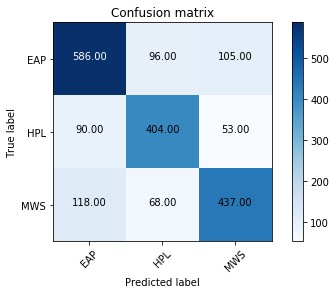

In [93]:
# error analysis
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

preds = format_nn_preds(encoder.classes_, numerical_preds)
conf_mat = confusion_matrix(Y_test, preds)


# NOTE: this function taken from: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = 500
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()

plot_confusion_matrix(conf_mat, classes=encoder.classes_,
                      title="Confusion matrix")
plt.show()

In [ ]:
# ANALYSIS: NN confusse MWS with EAP more than other combos

# [good place to insert val vs. test metrics]

In [ ]:
logtime()